## <center> **<span style="color: red">NLP</span> steps and explnation.**

Here we will use <span style="color: #ffd21e">**Hugging face**</span> trasformers pre trained models becuase it'll take so much effort to label<br>
all of our text columns "<ins>Comments, Describtion, Title</ins>" and also we will extract categorical and numirecal<br>
features from the text columns.<br><br>

##### **Steps in detail:**
<ul>
    <li>Extract categorical features from text columns sush as:<ol> 
        <li>Contains emojies
        <li>Positive or negative
        <li>language</ol>
    <li> Doing analysis for most common words in comments and titles (Word cloud)
    <li> Extracing the length of the comments, descriptions & titles
    <li> Stemming the data and tokenizing it
    <li> Saving those new data into new <strong>one</strong> Df to use in the final ML model

## <center> **Importing the <span style="color: red">Packeges</span>**<br>

In [37]:
import os
import time
import nltk
import emoji
import sqlite3
import svgwrite
import pandas as pd
import numpy as np
import transformers
import huggingface_hub

from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import (
    set_matplotlib_formats)

from wordcloud import (WordCloud,
                       STOPWORDS,
                       ImageColorGenerator)

huggingface_hub.notebook_login()
set_matplotlib_formats('pdf', 'svg')

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15492\1364707940.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## <center> **Reading the <span style="color: red">data</span>**

In [2]:
con = sqlite3.connect('../database.db')

df = pd.read_sql_query("""   
                        
                        SELECT *
                        FROM base_videos AS bv

                        INNER JOIN base_channels  AS bc ON
                            bc.channel_name = bv.channelTitle

                        INNER JOIN comments  AS c ON
                            c.video_id = bv.video_id""", con)

con.close()

df = df.T.drop_duplicates().T # dropping duplicated cols

In [3]:
df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,duration_in_minutes,subscribers,total_views,date,video_count,about,country,Comments,LikeCounts,ReplyCounts
2054,SUkpWNAhXUg,Griffin Gaming,"Dr Disrespect's ""Halo Infinite Will FAIL witho...",DrDisrespect recently had on of the worst tkae...,"['Griffin', 'Gaming', 'dr disrespect', 'dr dis...",2021-11-02 19:00:17+00:00,117792,7576,1847,hd,24.84375,220000,44449644,2013-11-05 00:00:00,319,Gaming,US,This aged well.,1,0
2658,TRG9E_icH50,Frostbite Gaming,GTA 5 FACE TO FACE CHALLENGE CHOP GOVES OVER ME,GTA 5 FACE TO FACE CHALLENGE CHOP GOVES OVER M...,"['gta', 'gta 5', 'gta 5 gameplay', 'gta v', 'g...",2023-03-24 05:45:01+00:00,212705,7203,370,hd,10.867188,5100000,3075034432,2014-05-04 00:00:00,1602,My name is Dhawan Aryan. My friends call me Ya...,IN,Bhai froty free fire khelo na....plz,0,0
6031,bOjM0qCtGlo,Gaming Insects,😂Fooling This Girl Using Shapeshift Mod in Min...,😂Fooling This Girl Using Shapeshift Mod in Min...,['I Secretly Install This Shapeshift Mod To Fo...,2022-12-19 07:30:08+00:00,389131,13869,394,hd,21.171875,694000,79491185,2019-08-22 00:00:00,415,Guys Im Trying My Best Ki App Logo Ko Bohot En...,IN,❤❤❤❤❤🎉🎉🎉🎉থরয়য়দঢ়মদথঢ়মরদণম,0,0
794,maaCpUo6a80,VeryNuclear Gaming,GTA 5: UPGRADING TO GOD WEAPONS TO TAKE REVENG...,Last Video (IMPOSSIBLE SUPERCAR PARKOUR CHALLE...,"['very nuclear', 'gta 5', 'grand theft auto', ...",2023-02-09 08:00:19+00:00,576556,19022,574,hd,11.21875,300000,19245086,2021-05-14 00:00:00,49,Join VeryNuclear & Friends on their Racing Adv...,IN,@\n10/10,0,0
3762,mo0ORZsf8V4,Zamfam Gaming,Choosing a New Babysitter for Our Daughter,Which babysitter should we go with? In this L...,"['choosing', 'new', 'babysitter', 'daughter', ...",2022-05-06 18:35:27+00:00,570576,12456,735,hd,10.679688,938000,83266884,2020-11-26 00:00:00,85,,US,I think mike should be the babysitter,1,0


##  <center> **Extract <span style="color: red">categorical</span> features**

#### *Extract emojies count per text*

In [4]:
comments_emojis_counts: list = []
title_emojis_counts: list = []
desc_emojis_counts: list = []

for comment, title, desc in zip(df["Comments"], df["title"], df["description"]):
    
    comments_emojis_count: int = 0
    title_emojis_count: int = 0
    desc_emojis_count: int = 0
    
    for comment_char, title_char, desc_char in zip(comment, title, desc):
        
        if emoji.is_emoji(comment_char):
            comments_emojis_count += 1
            
        if emoji.is_emoji(title_char):
            title_emojis_count += 1
            
        if emoji.is_emoji(desc_char):
            desc_emojis_count += 1
    
    comments_emojis_counts.append(comments_emojis_count)
    title_emojis_counts.append(title_emojis_count)
    desc_emojis_counts.append(desc_emojis_count)

In [5]:
df["comments_emojis_count"] = comments_emojis_counts
df["title_emojis_count"] = title_emojis_counts
df["desc_emojis_count"] = desc_emojis_counts

df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,...,date,video_count,about,country,Comments,LikeCounts,ReplyCounts,comments_emojis_count,title_emojis_count,desc_emojis_count
1202,CzZuuw8l8_U,Judo Sloth Gaming,I Upgraded a New Account to Town Hall 15 in On...,How much does it cost to Gem from Town Hall 1 ...,"['clash of clans', 'coc', 'clash of clans game...",2022-10-19 14:30:06+00:00,2384473,80759,2516,hd,...,2014-02-04 00:00:00,1784,A Clash of Clans based channel focusing on hel...,GB,Do to th16,0,0,0,0,0
352,9WXBjOS5pzA,Gaming Tamizhan,😱அருமையான ஆட்டம்.!! || Free Fire Attacking Sol...,😱அருமையான ஆட்டம்.!! || Free Fire Attacking Sol...,"['gt king', 'gt live', 'gaming tamizhan', 'new...",2023-03-26 09:00:05+00:00,32525,4685,182,hd,...,2019-01-18 00:00:00,1302,Solrathuku Onnum ila Ithu 10 Min Fun Panra Cha...,IN,Please 🥺❤️❤️🥺 Pro,1,0,4,1,1
4362,GX5U01Qj2V4,LiteWeight Gaming,The Fast and the Frenchiest - GTA IV: Pt. 7 - ...,In this first play through video of Grand Thef...,"['Gta 4', 'gta iv', 'grand theft auto 4', 'gra...",2023-03-18 18:30:22+00:00,11628,723,227,hd,...,2019-02-09 00:00:00,859,Welcome to the Let's Play and Reaction channel...,US,Gonna need some oh boy! Lightweight t shirts a...,0,1,1,0,0
4411,YFl9m2cjMq8,PAYAL GAMING,YOUR REGULAR STREAMER IS HERE ⚡❤️‍🔥|| PAYAL IS...,https://linktr.ee/AMDgaminguniverse\n\n➤ Becom...,"['PAYAL', 'PAYAL GAMING', 'Payal gaming LIVE',...",2023-02-17 19:10:21+00:00,128105,12738,244,hd,...,2019-03-01 00:00:00,609,Hey there! Welcome to my channel! My name is P...,IN,Tumara bf kon hai,0,0,0,0,0
2338,Kp6-jAq6vXY,Daxua Gaming,OMG😱Tips And Trick Screen Shake Reflex⚡️Improv...,A 18 Years Old Vietnam 🇻🇳 God Level Skills And...,"['pubg bgmi', 'screen shake pubg mobile', 'scr...",2023-03-04 15:08:12+00:00,53916,2755,179,hd,...,2019-09-28 00:00:00,854,Follow me on Facebook: https://www.facebook.co...,IN,Продам аккаунт м416 ледник и мумия,0,0,0,1,0


#### *Language detection*

In [8]:
language_detector = transformers.pipeline("text-classification",
                                          model="papluca/xlm-roberta-base-language-detection",
                                          use_auth_token= True)

In [9]:
%%timeit
print(language_detector("هذا أطول نص قد تقرأه على الإطلاق إنه طويل للغاية", max_length=128))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
1.89 s ± 80.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like we will take a lot to <ins>just classify the language</ins> of each text at least: $30\times100$ second whitch equalls <span style="color: red">**50 minutes.**</span><br>
So we can't do translation for now becuase it at least may take **5 hours** to run so we will just use this language detetion and<br>
optimize it by just sellecting one text column to detect which will be **Description column** and use the detected languages to<br>
pridect video and comments language.<br><br>
But we will detect the language using the **country of this video**

In [10]:
df["country"].unique()

array(['DE', 'US', 'PL', 'SA', 'NP', 'CA', 'ES', 'TR', 'IN', 'EG', 'GB',
       'MX', 'BR', 'PK', 'FR', 'VN', 'ID', 'AU', 'HU', 'NL', 'BG', 'JP',
       'SG', 'TH', 'PH', 'MT', 'PE', 'SE', 'IT', 'KR', 'TW', 'FI', 'DZ',
       'BD', 'AR'], dtype=object)

In [11]:
country_languages = {
    'DE': 'German',
    'US': 'English', 'PL': 'Polish',
    'SA': 'Arabic', 'NP': 'Nepali',
    'CA': 'English', 'ES': 'Spanish',
    'TR': 'Turkish', 'IN': 'Hindi',
    'EG': 'Arabic', 'GB': 'English',
    'MX': 'Spanish', 'BR': 'Portuguese',
    'PK': 'Urdu', 'FR': 'French',
    'VN': 'Vietnamese', 'ID': 'Indonesian',
    'AU': 'English', 'HU': 'Hungarian',
    'NL': 'Dutch', 'BG': 'Bulgarian',
    'JP': 'Japanese', 'SG': 'English', 
    'TH': 'Thai', 'PH': 'Tagalog',
    'MT': 'Maltese', 'PE': 'Spanish',
    'SE': 'Swedish', 'IT': 'Italian',
    'KR': 'Korean', 'TW': 'Chinese',
    'FI': 'Finnish', 'DZ': 'Arabic',
    'BD': 'Bengali', 'AR': 'Spanish'}

df["language"] = df["country"].replace(country_languages)

This wy may not be so accurate in detecting languages becuase there are some **indian videos** specifically with english and<br>
because some commetns come in deffrint languages but at least this way is more accurate than `roberta-language-detection`<br>
model because this model sometimes come with wierd 

#### *Sentiment analysis*

In [10]:
sentiment_classifier = transformers.pipeline(model= "finiteautomata/bertweet-base-sentiment-analysis")
print(sentiment_classifier("Hello here in my analysis, Have a nice day !!"))

Downloading:   0%|          | 0.00/2.70k [00:00<?, ?B/s]

[{'label': 'POS', 'score': 0.9883897304534912}]


In [11]:
def my_sentiment_classifier(text: str) -> np.int8:
    """This code takes a text and return you if it's positive
        or negative as 1 for positive, 0 for natural -1 for negative
        and -10 for unclassified.
    
    @params: a string text
    @return: 1, 0 or -1 in np.int8 dtype"""
    
    sentiment_type_encoder: dict = {"POS": 1,
                                    "NEG": -1,
                                    "NEU": 0,
                                    "unclassified": -10}
    
    try:
        sentiment_type: str = sentiment_classifier(text)[0]["label"]
        
    except:
        sentiment_type: str = "unclassified"
        
    return  np.int8(sentiment_type_encoder[sentiment_type])

In [84]:
df["sentiments"] = df["Comments"][:5].apply(
    lambda x: my_sentiment_classifier(x))

In [13]:
df[["sentiments", "Comments"]]

,sentiments,comments
0,1.0,2022 has been amazing. Can’t wait for 2023 Tri...
1,0.0,3:20 THAT'S WILD 💀💀💀
2,0.0,"I know this is a couple of weeks old, but does..."
3,1.0,I miss Pat
4,1.0,I miss Pat in these videos.
...,...,...
2035,NaN,The mafia 💙💙ko bulau
2036,NaN,Tu khali bakchodi hi karta he kiya .. game pla...
2037,NaN,Tufan is good 😊
2038,NaN,very nice video❤❤❤


## <center><strong>Text visualiztion with<span style = "color: red"> WordCloud</span></strong></center>

In [54]:
coloring = np.array(Image.open("../imgs/youtube_gaming_logo.png"))
stopwords = set(STOPWORDS)

comments = ''.join(df["Comments"][df["language"] == "English"].values.flatten())

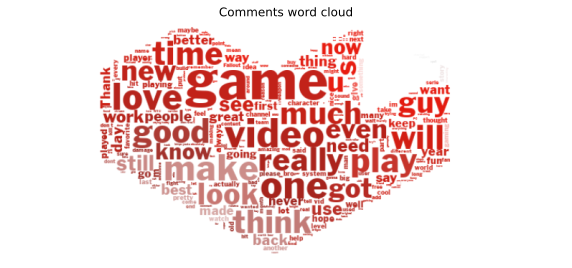

In [55]:
wc = WordCloud(background_color= "white", max_words= 2000, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf')

wc.generate(comments)

image_colors = ImageColorGenerator(np.array(coloring))

fig, ax = plt.subplots(1)

ax.imshow(wc.recolor(color_func= image_colors), interpolation="bilinear")
ax.set_axis_off()

plt.title("Comments word cloud")
fig.set_size_inches(10, 6)
plt.savefig("../plots/comments_word_cloud.png")
plt.show()

Now we will make a word cloud for **video titles data**

In [51]:
more_popular_emojis = ["😊", "😍", "😘", "😜", "😝", "😂", "😭", "😡", "😠", "😩", "😫", "😞", "😟", "😢", "😥", "😰", "😱",
                       "😳", "😷", "👍", "👎", "👌", "👏", "🙌", "👋", "💪", "🙏", "❤️", "💔", "💕", "💖", "💘", "💙", "💚",
                       "💛", "💜", "💯", "🔥", "🌟", "✨", "⭐", "🌈", "🌺", "🍕", "🍔", "🍟", "🍦", "🍭", "🍩", "🍪", "🍺",
                       "🍻", "🍷", "🍸", "🎂", "🎁", "🎉", "🎊", "🎈", "🎵", "🎶", "🎼", "🎧", "🎤", "🎸", "🎹", "🎺", "🎷",
                       "🎻", "🎬", "🎥", "🎦", "📷", "📹", "📺", "📻", "💻", "📱", "💡", "🔑", "🔨", "🔥", "💰", "💳", "💼",
                       "📅", "📆", "📈", "📉", "📊", "📋", "📎", "📏", "📐", "🔒", "🔓", "🔍", "🔎", "🚀", "🚑", "🚒", "🚓",
                       "🚕", "🚗", "🚙", "🚚", "🚢", "🚤", "🚲", "🚶", "🚶‍♀️", "🏃", "🏃‍♀️", "⚽", "🏀", "🏈", "🎾", "🏐", "🏉",
                       "🎱", "🏓", "🏸", "🥊", "🥋", "🎮", "🕹️", "🎲", "🃏"]


for emoji in popular_emojis:
    stopwords.add(emoji)
    
titels = ''.join(df["title"][df["language"] == "English"].values.flatten())

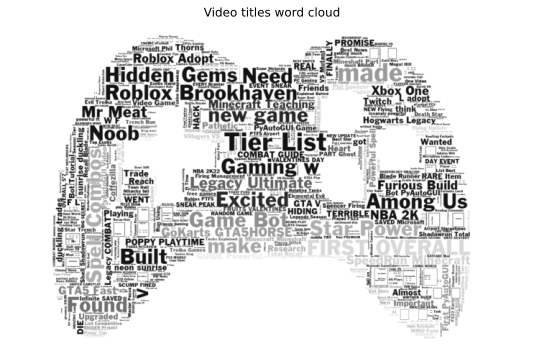

In [56]:
coloring = np.array(Image.open("../imgs/joystick.png"))

wc = WordCloud(background_color= "white", max_words= 2000, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf')

wc.generate(titels)

image_colors = ImageColorGenerator(np.array(coloring))

fig, ax = plt.subplots(1)

ax.imshow(wc.recolor(color_func= image_colors), interpolation= "bilinear")
ax.set_axis_off()


plt.title("Video titles word cloud")
fig.set_size_inches(10, 6)
plt.savefig("../plots/videos_titels_word_cloud.png")
plt.show()

## <center><strong><span style = "color: red">Extra</span> features